In [271]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

RANDOM_STATE=42

In [250]:
data = pd.read_csv("data/data_untreated.csv")

# Data preprocessing

### Rename columns

Making the dataset easier to handle

In [251]:
attributes = {
    'Year': "year",
    'CountryName': "country",
    'GDP per capita (constant LCU)': "gdp",
    'Unemployment, total (% of total labor force)': "unemployment",
    'Consumer price index (2010 = 100)': "cpi",
    'Central government debt, total (% of GDP)': "cgd",
    'suicides_no': "suicides",
    'population': "population"
}
data.rename(index=str, columns=attributes, inplace = True)
data.head()

,year,country,cgd,cpi,gdp,unemployment,suicides,population
0,1995,Albania,35.288883,40.762778,99602.052864,16.900000,88.0,2903400.0
1,1995,Antigua and Barbuda,NaN,NaN,26247.765147,NaN,0.0,66846.0
2,1995,Argentina,NaN,NaN,13339.409635,18.799999,2204.0,31345400.0
3,1995,Armenia,NaN,44.286056,193776.500640,24.000000,130.0,3443200.0
4,1995,Aruba,NaN,62.495164,34337.947862,NaN,8.0,73581.0


### Correlations

Checking correlations between all attributes

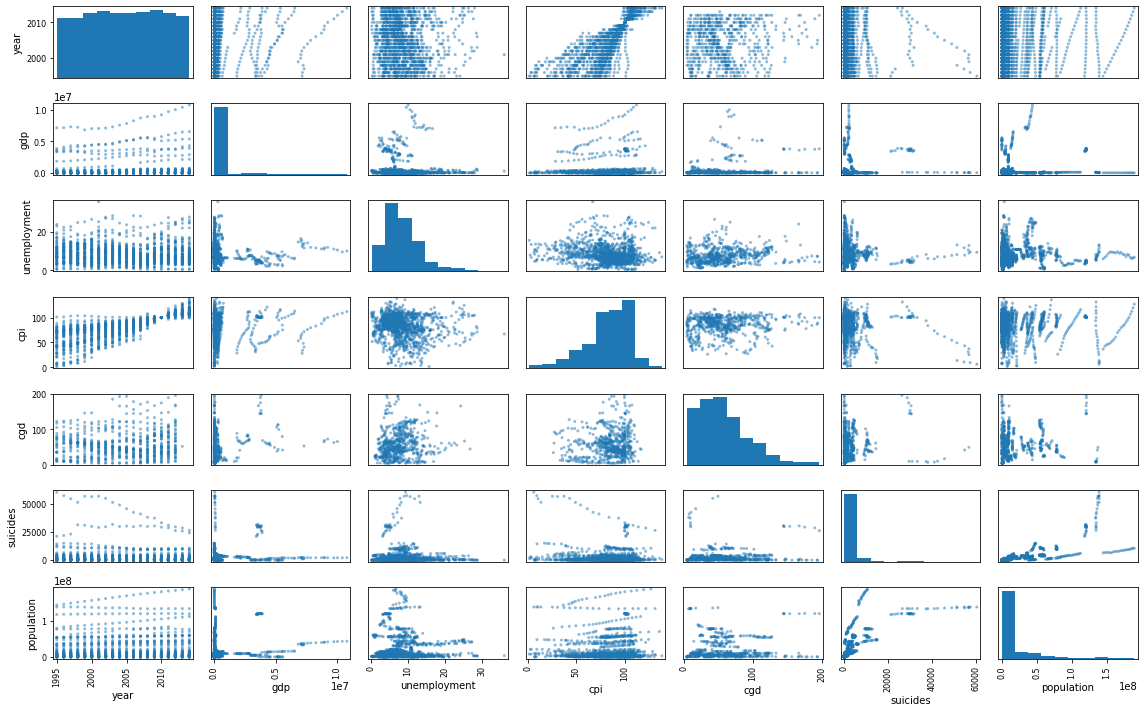

In [252]:
sm = pd.plotting.scatter_matrix(data[list(attributes.values())], figsize=(16, 10))
[s.xaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(90) for s in sm.reshape(-1)]
plt.tight_layout()
plt.show()

In [253]:
corr_matrix = data.corr()
corr_matrix["suicides"].sort_values(ascending=False)

suicides        1.000000
population      0.727417
gdp             0.093172
cgd             0.051901
year           -0.036505
unemployment   -0.047083
cpi            -0.097961
Name: suicides, dtype: float64

Setting target variable to be the percentage of population who committed suicide, given the very high correlation between these two variables.

In [254]:
data['suicides'] = data['suicides'] / data['population']
data.rename(index=str, columns={'suicides': 'suicides_over_population'}, inplace = True)
data.drop(labels=['population'], axis=1, inplace=True)

Checking linear relationship between unemployment rates and percentage of population who committed suicide

array([[<AxesSubplot:xlabel='unemployment', ylabel='unemployment'>,
        <AxesSubplot:xlabel='suicides_over_population', ylabel='unemployment'>],
       [<AxesSubplot:xlabel='unemployment', ylabel='suicides_over_population'>,
        <AxesSubplot:xlabel='suicides_over_population', ylabel='suicides_over_population'>]],
      dtype=object)

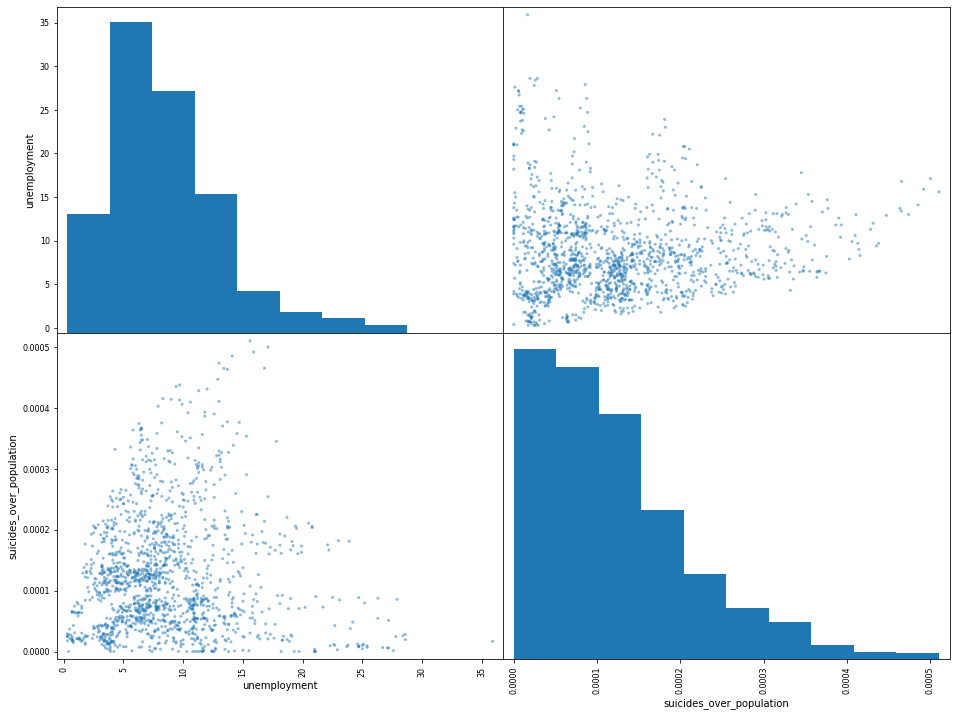

In [255]:
unemployment_data = data.copy()
pd.plotting.scatter_matrix(unemployment_data[['unemployment', 'suicides_over_population']], figsize=(16, 12))

### Split dataset

In [256]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)

### Imputation

Filling in missing numerical values

In [257]:
#train_set.info()

In [258]:
num_vars = ["cgd", "cpi", "gdp", "unemployment"]

In [259]:
imputer = SimpleImputer(strategy="median")
imputer.fit(train_set[num_vars])

SimpleImputer(strategy='median')

In [260]:
train_set[num_vars] = imputer.transform(train_set[num_vars])

/home/tiago/Documents/Projects/python-projects/economics-for-suicide-prediction/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/tiago/Documents/Projects/python-projects/economics-for-suicide-prediction/env/lib/python3.6/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


### Categorical variable encoding

Encoding years as ordinal variables

In [261]:
ord_vars = ["year"] 

In [262]:
ordinal_encoder = OrdinalEncoder()
train_set[ord_vars] = ordinal_encoder.fit_transform(train_set[ord_vars])

/home/tiago/Documents/Projects/python-projects/economics-for-suicide-prediction/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/tiago/Documents/Projects/python-projects/economics-for-suicide-prediction/env/lib/python3.6/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Encoding countries with one-hot encoding

See the following links for more info on using OHE:
1. https://stackoverflow.com/questions/55525195/do-i-have-to-do-one-hot-encoding-separately-for-train-and-test-dataset
2. https://stackoverflow.com/questions/58101126/using-scikit-learn-onehotencoder-with-a-pandas-dataframe

I considered exploring other methods of categorical encoding but ended up going with one-hot encoding, since the number of unique countries outweighs the number of datapoints a hundredfold.
See https://www.kaggle.com/subinium/11-categorical-encoders-and-benchmark for more info on categorical encoders.

In [263]:
cat_vars = ["country"]

In [264]:
train_set = pd.concat([train_set, pd.get_dummies(train_set[cat_vars], prefix=cat_vars[0], drop_first=True)], axis=1)
train_set.drop(labels=cat_vars, axis=1, inplace=True)

### Feature scaling

In [265]:
scaler = StandardScaler()
train_set[num_vars + ord_vars] = scaler.fit_transform(train_set[num_vars + ord_vars])
train_set.head()

,year,cgd,cpi,gdp,unemployment,suicides_over_population,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Aruba,...,country_Switzerland,country_Thailand,country_Trinidad and Tobago,country_Turkey,country_Turkmenistan,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_Uruguay,country_Uzbekistan
1200,0.935078,-0.135905,0.760402,-0.007276,0.578946,0.000305,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
782,0.057163,-0.135905,-0.896774,-0.041464,-0.409081,0.000070,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1235,0.935078,-0.135905,0.760402,-0.301560,3.395872,0.000009,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
772,0.057163,-0.135905,0.193131,-0.334938,-0.871561,0.000051,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1255,1.110661,-0.135905,1.188316,-0.338282,0.557924,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TODO: Preprocess dataset using scikit pipelines

In [ ]:
"""
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_vars),
    ("ord", OrdinalEncoder(), ord_vars),
    ("cat", MyOneHotEncoder(), cat_vars),
    
])
"""

In [ ]:
# Utils
np.set_printoptions(threshold=False)

# Model building

Experimenting with a couple of different models and comparing results.

### 1. Linear regression

In [270]:
lin_reg = LinearRegression()
lin_reg.fit(train_set.drop('suicides_over_population', axis=1), train_set['suicides_over_population'])

LinearRegression()

In [276]:
# The following code is bad practice. MSE should not be analyzed on training data.
# Will test on proper data as soon as sklearn pipeline for preprocessing is built.
# For now, testing model building and metrics methods

predictions = lin_reg.predict(train_set.drop('suicides_over_population', axis=1))
labels = train_set['suicides_over_population']
lin_mse = mean_squared_error(predictions, labels)
lin_rmse = np.sqrt(lin_mse)
lin_rmse * 100

0.0027804953767859835